In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from geophys_utils import NetCDFGridUtils
from geophys_utils import NetCDFLineUtils
from geophys_utils import get_gdal_wcs_dataset, get_gdal_grid_values
from geophys_utils import get_spatial_ref_from_wkt, get_coordinate_transformation, get_utm_wkt, transform_coords
from geophys_utils._transect_utils import line_length, point_along_line, utm_coords, coords2distance, sample_transect

In [3]:
# Setup proxy as required
GA_STAFF_WIFI = False

if GA_STAFF_WIFI:
    os.environ['http_proxy'] = 'http://proxy.inno.lan:3128'
    os.environ['https_proxy'] = 'http://proxy.inno.lan:3128'

In [4]:
resampling_method = 'linear'

xres = 10.0 # 10m/pixel horizontally
yres = 1.0 # 1m/pixel vertically
    
# Number of subdivisions for each layer for interpolation. 
# Note that transition between layers will occur in lowest subdivision of uppermost layer
layer_subdivisions = 1

In [5]:
aem_nc_path = '/g/data2/uc0/rr2_dev/rcb547/AEM_examples/AUS_10008_WestK_LCI.nc'
if not os.path.isfile(aem_nc_path):
    aem_nc_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/rcb547/AEM_examples/AUS_10008_WestK_LCI.nc'

In [6]:
aem_nc_dataset = netCDF4.Dataset(aem_nc_path)

In [7]:
# The CRS definition in the file is INCORRECT in the test file! It specifies degrees, not metres.
bad_wkt = get_spatial_ref_from_wkt(aem_nc_dataset.variables['crs'].epsg_code).ExportToWkt()
bad_wkt

'GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]]'

In [8]:
# Get the WKT for the right CRS (even though we don't actually need it)
utm_wkt = get_utm_wkt((123.4, -18.01), 'EPSG:4326') # Coordinate in area of interest read from Google Earth
utm_wkt

'PROJCS["UTM Zone 51, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'

In [9]:
aem_nc_dataset.variables['line'].shape

(199,)

C:\Users\u76345\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in less


Line 103901 is of length 48507.43359375m
Line 103902 is of length 17397.57421875m
Line 150001 is of length 18317.1171875m
Line 150101 is of length 14347.8828125m
Line 150201 is of length 4580.7607421875m
Line 150202 is of length 8782.888671875m
Line 150301 is of length 22172.650390625m
Line 150401 is of length 10310.71484375m
Line 150501 is of length 18598.244140625m
Line 150601 is of length 7424.4619140625m


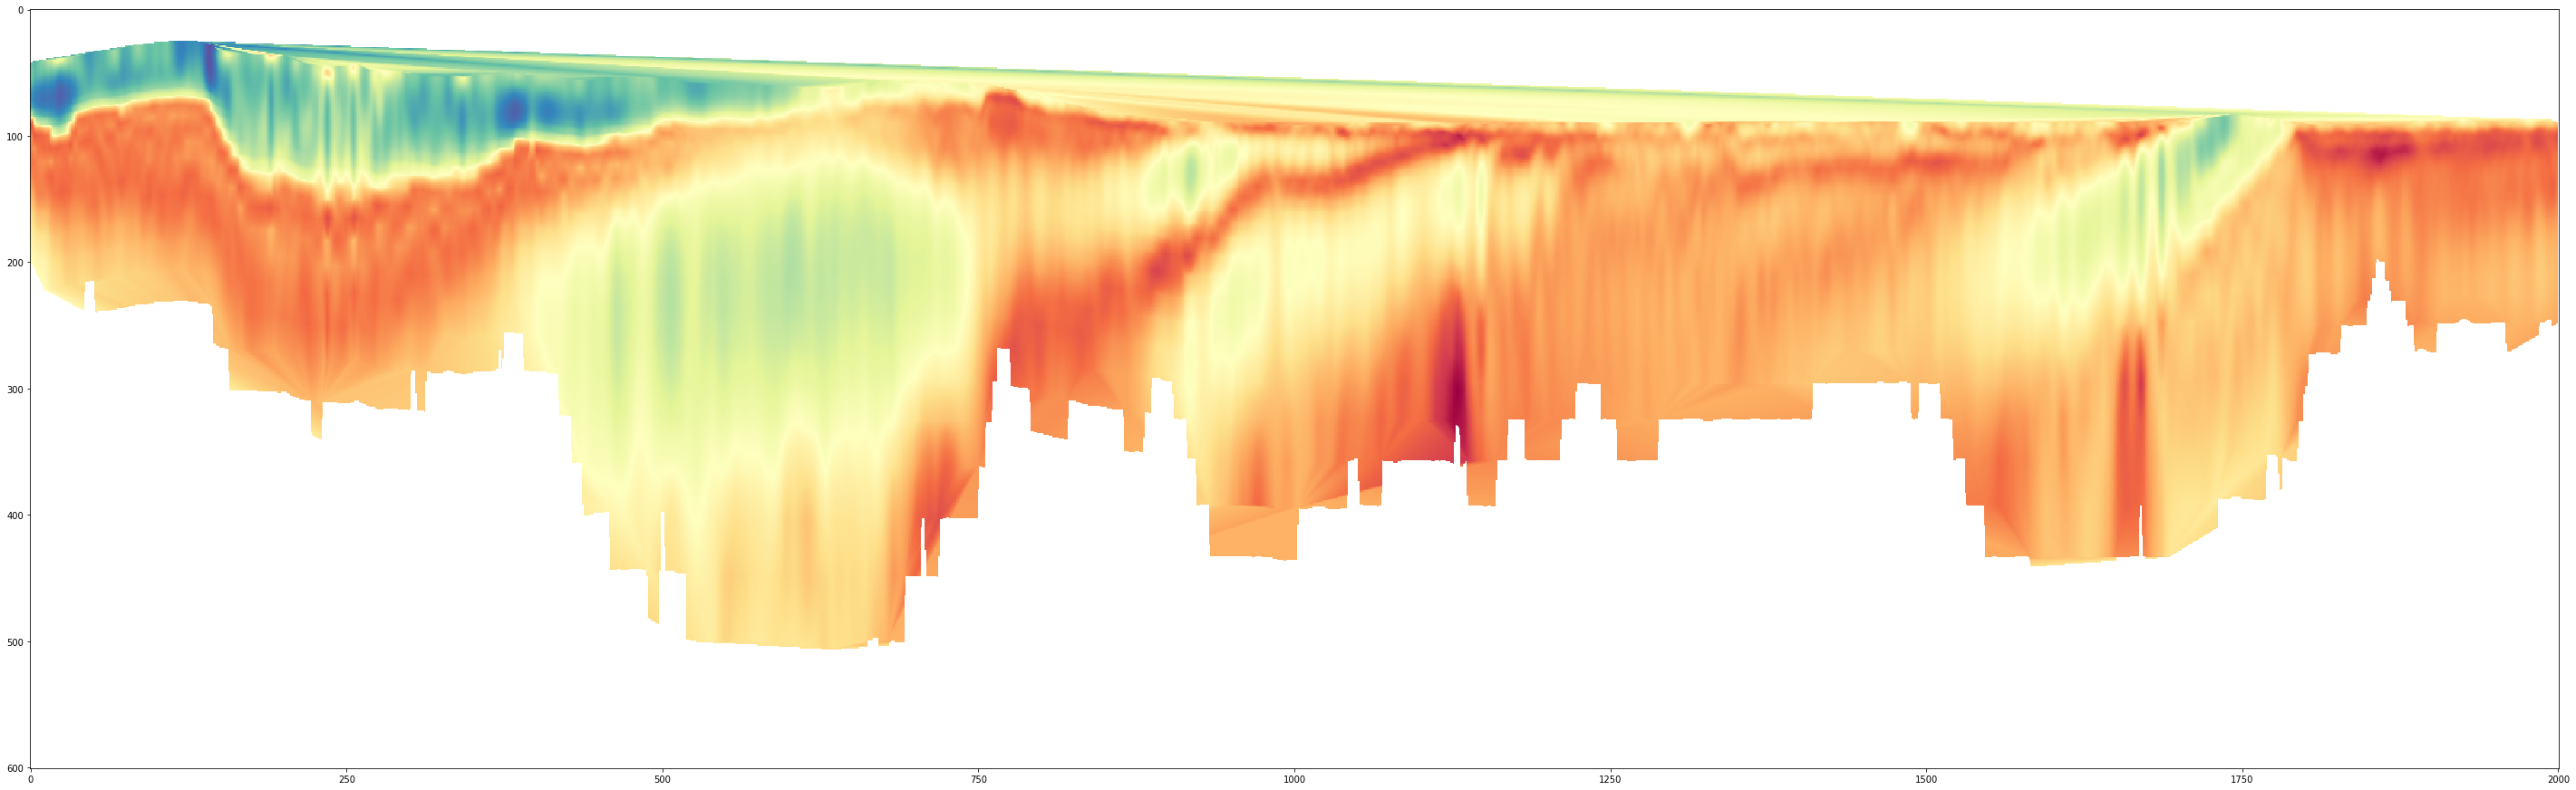

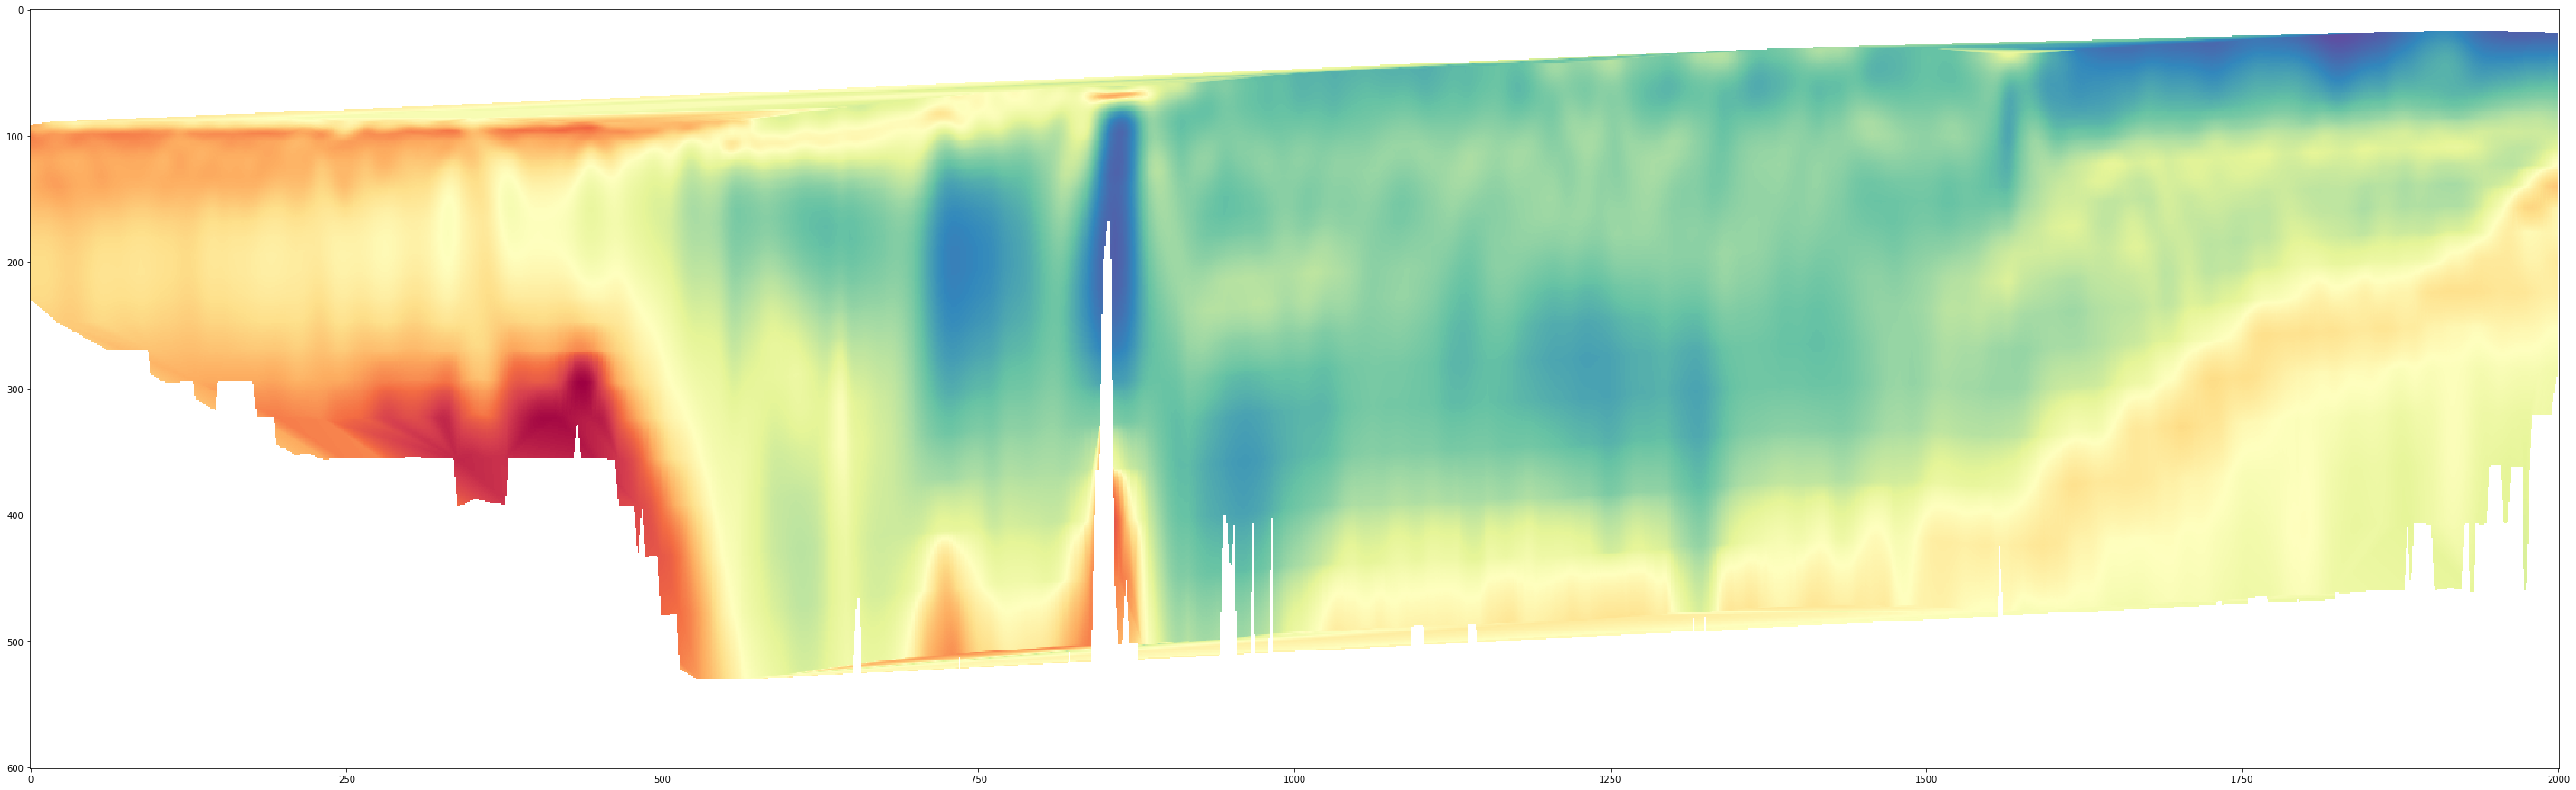

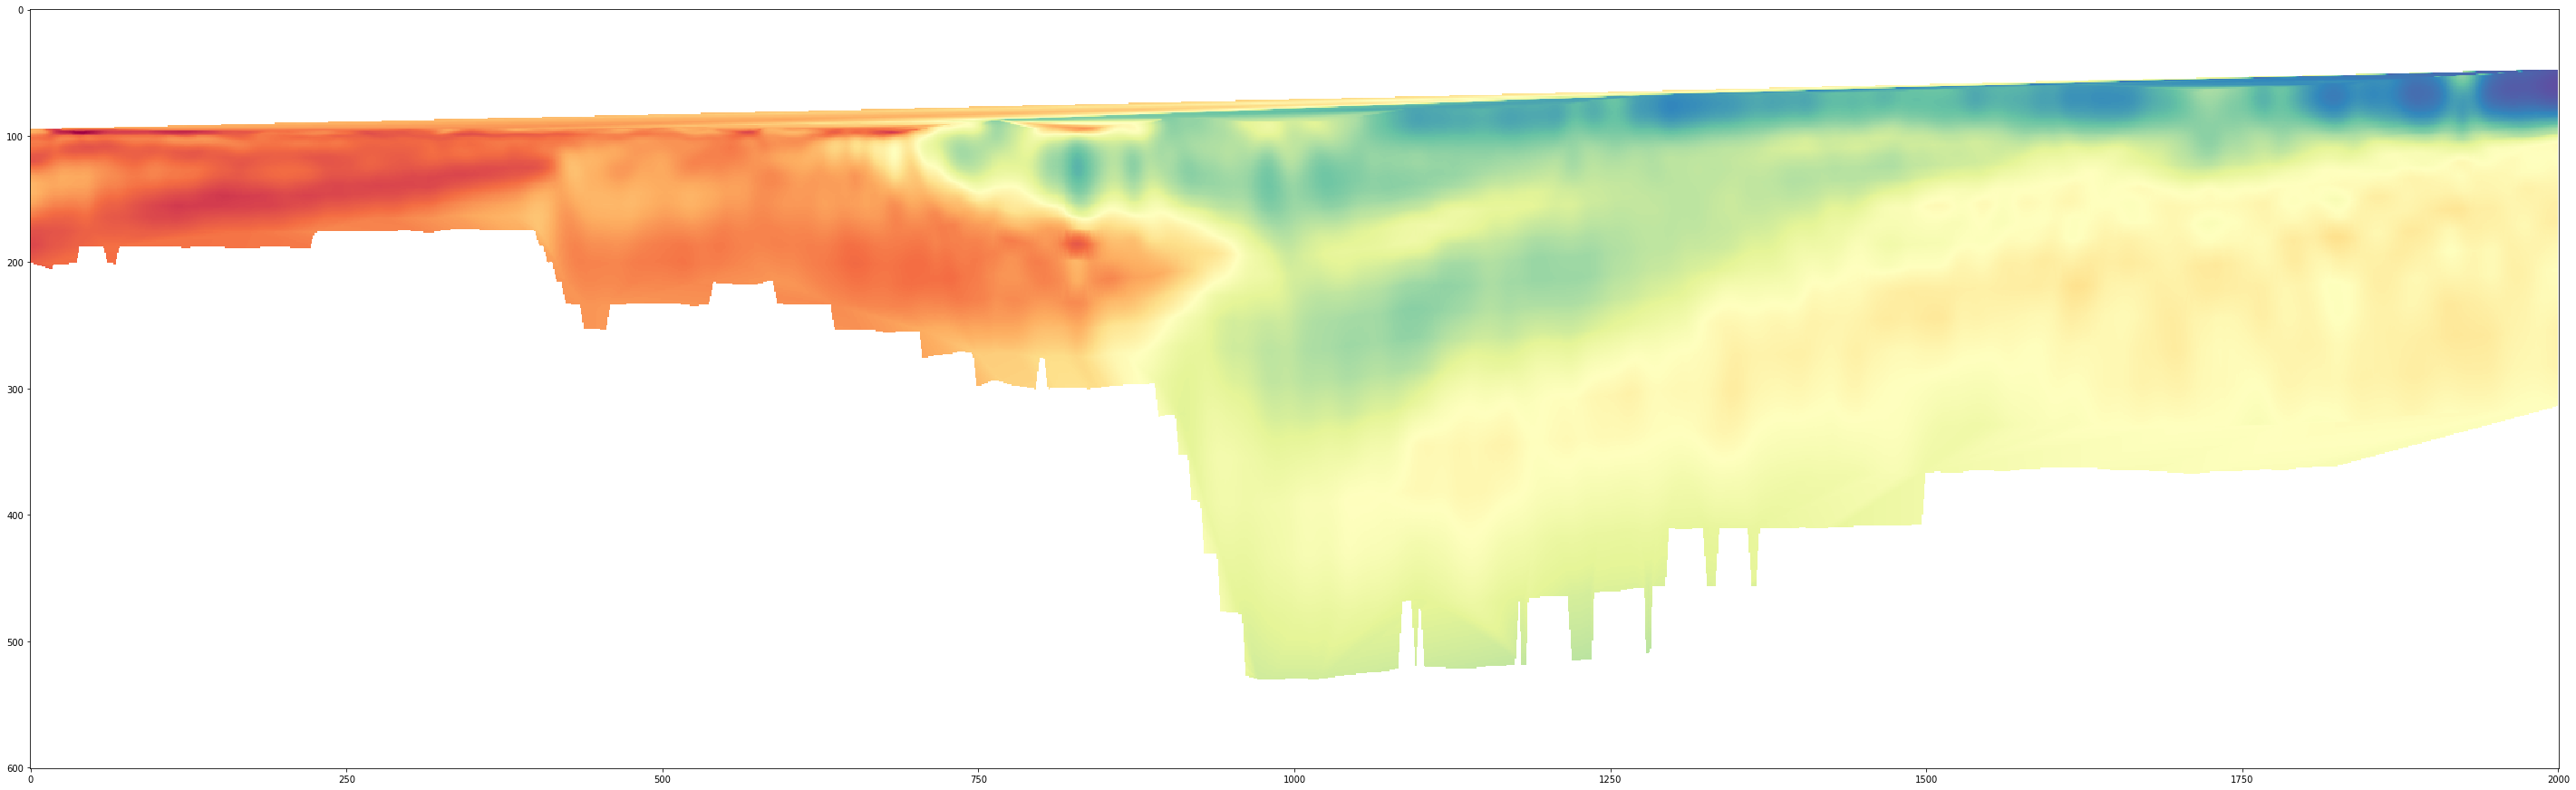

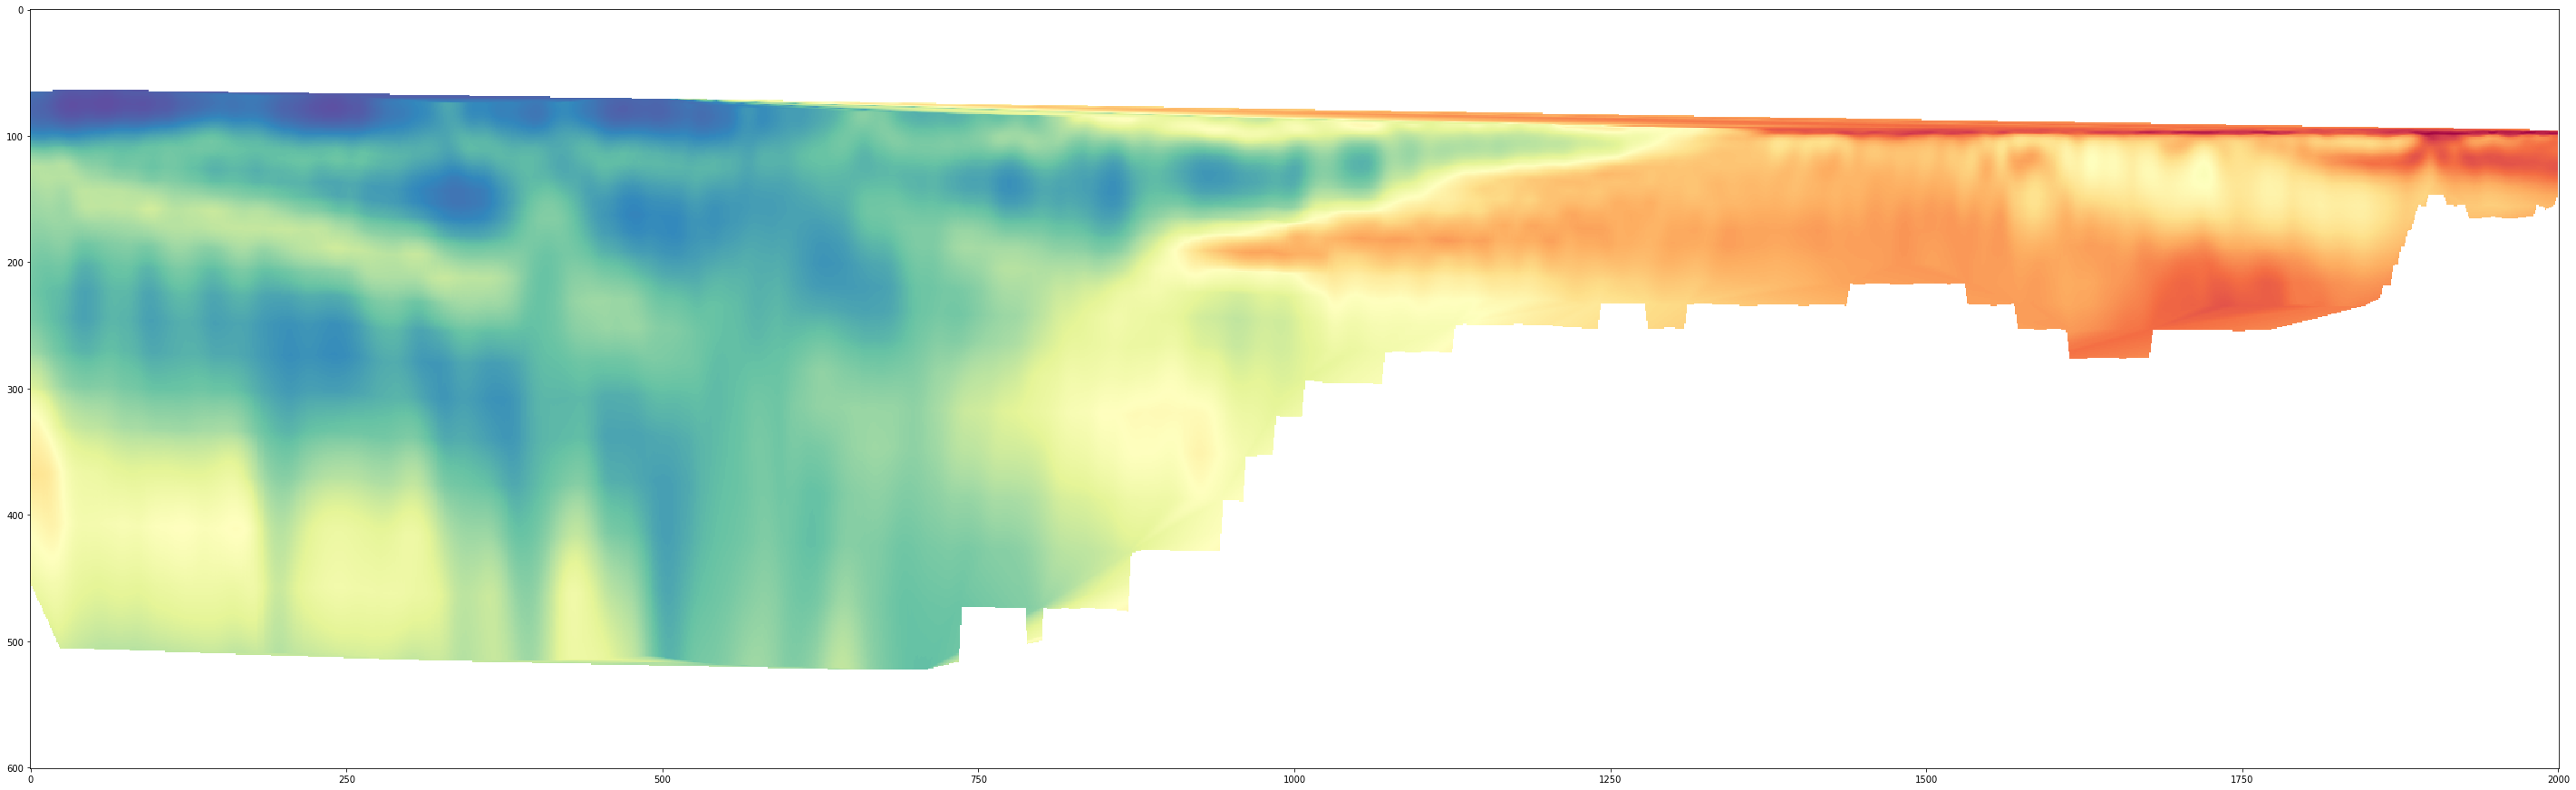

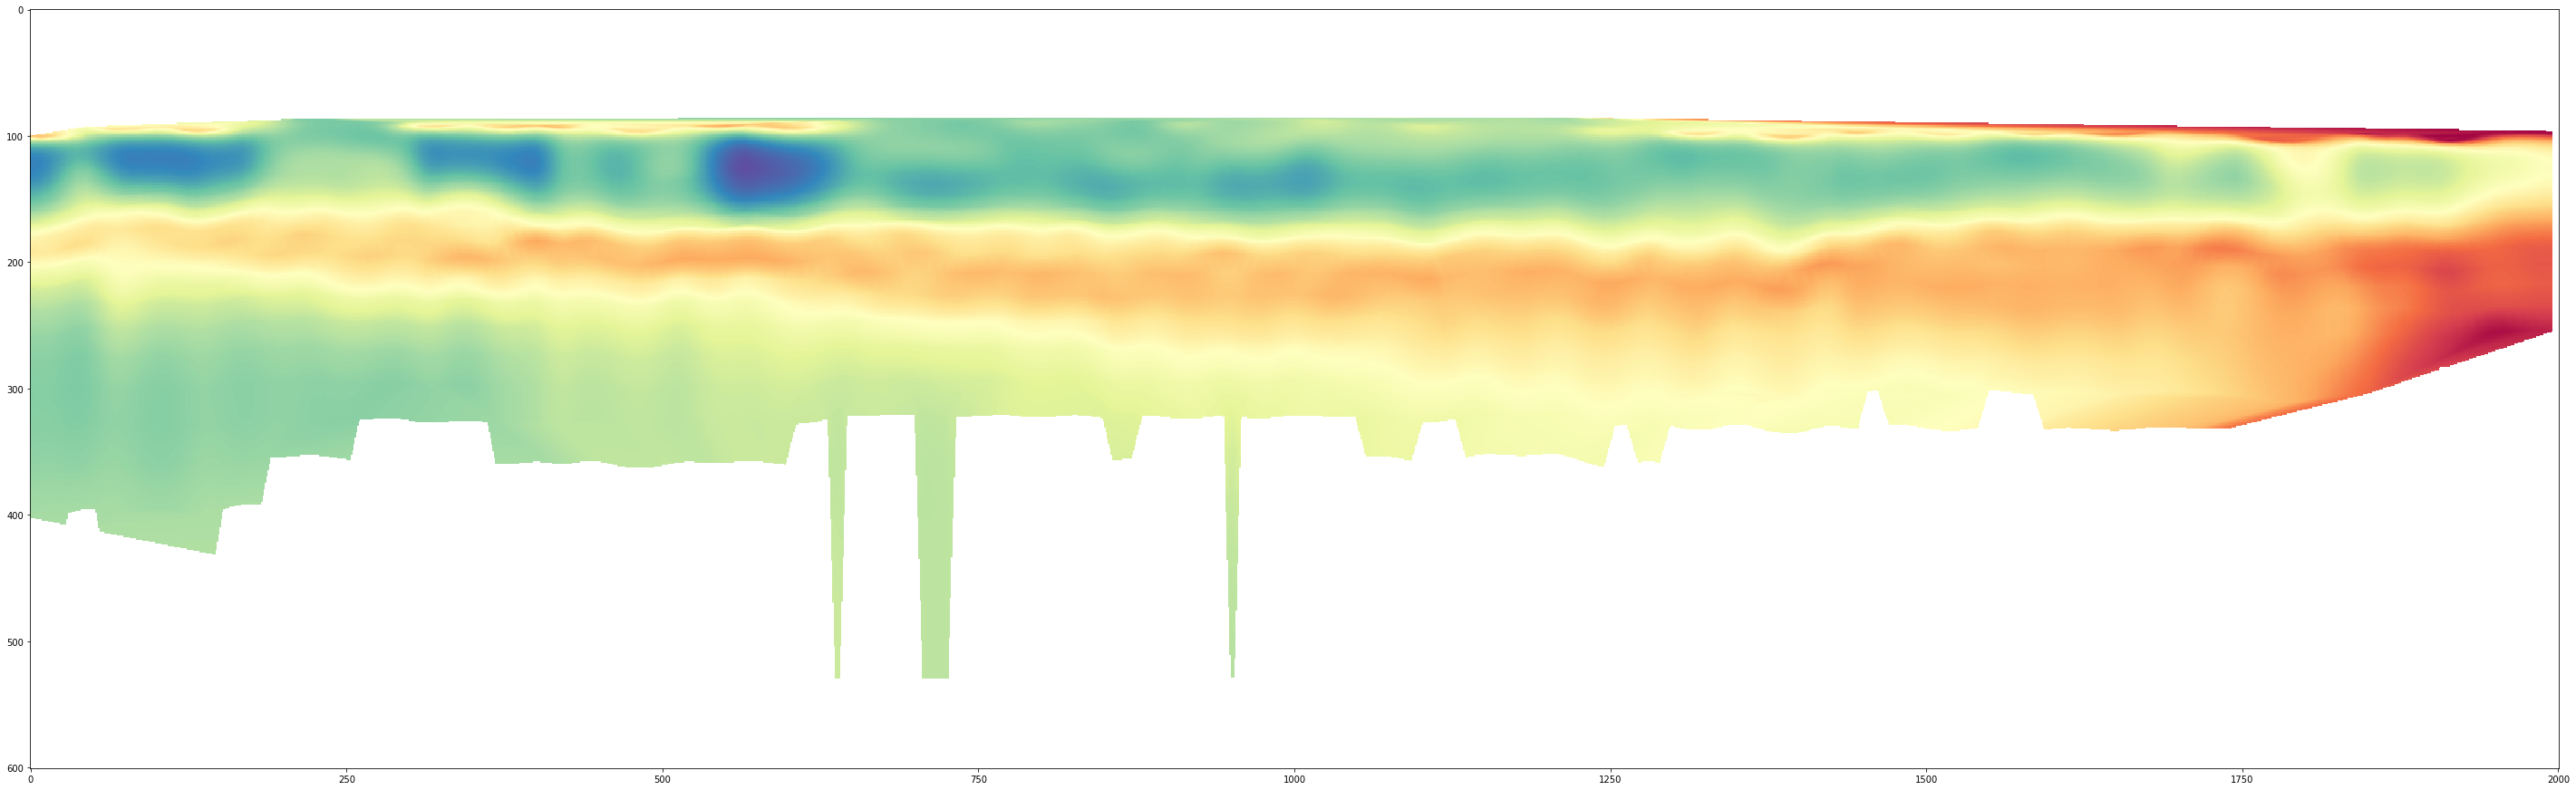

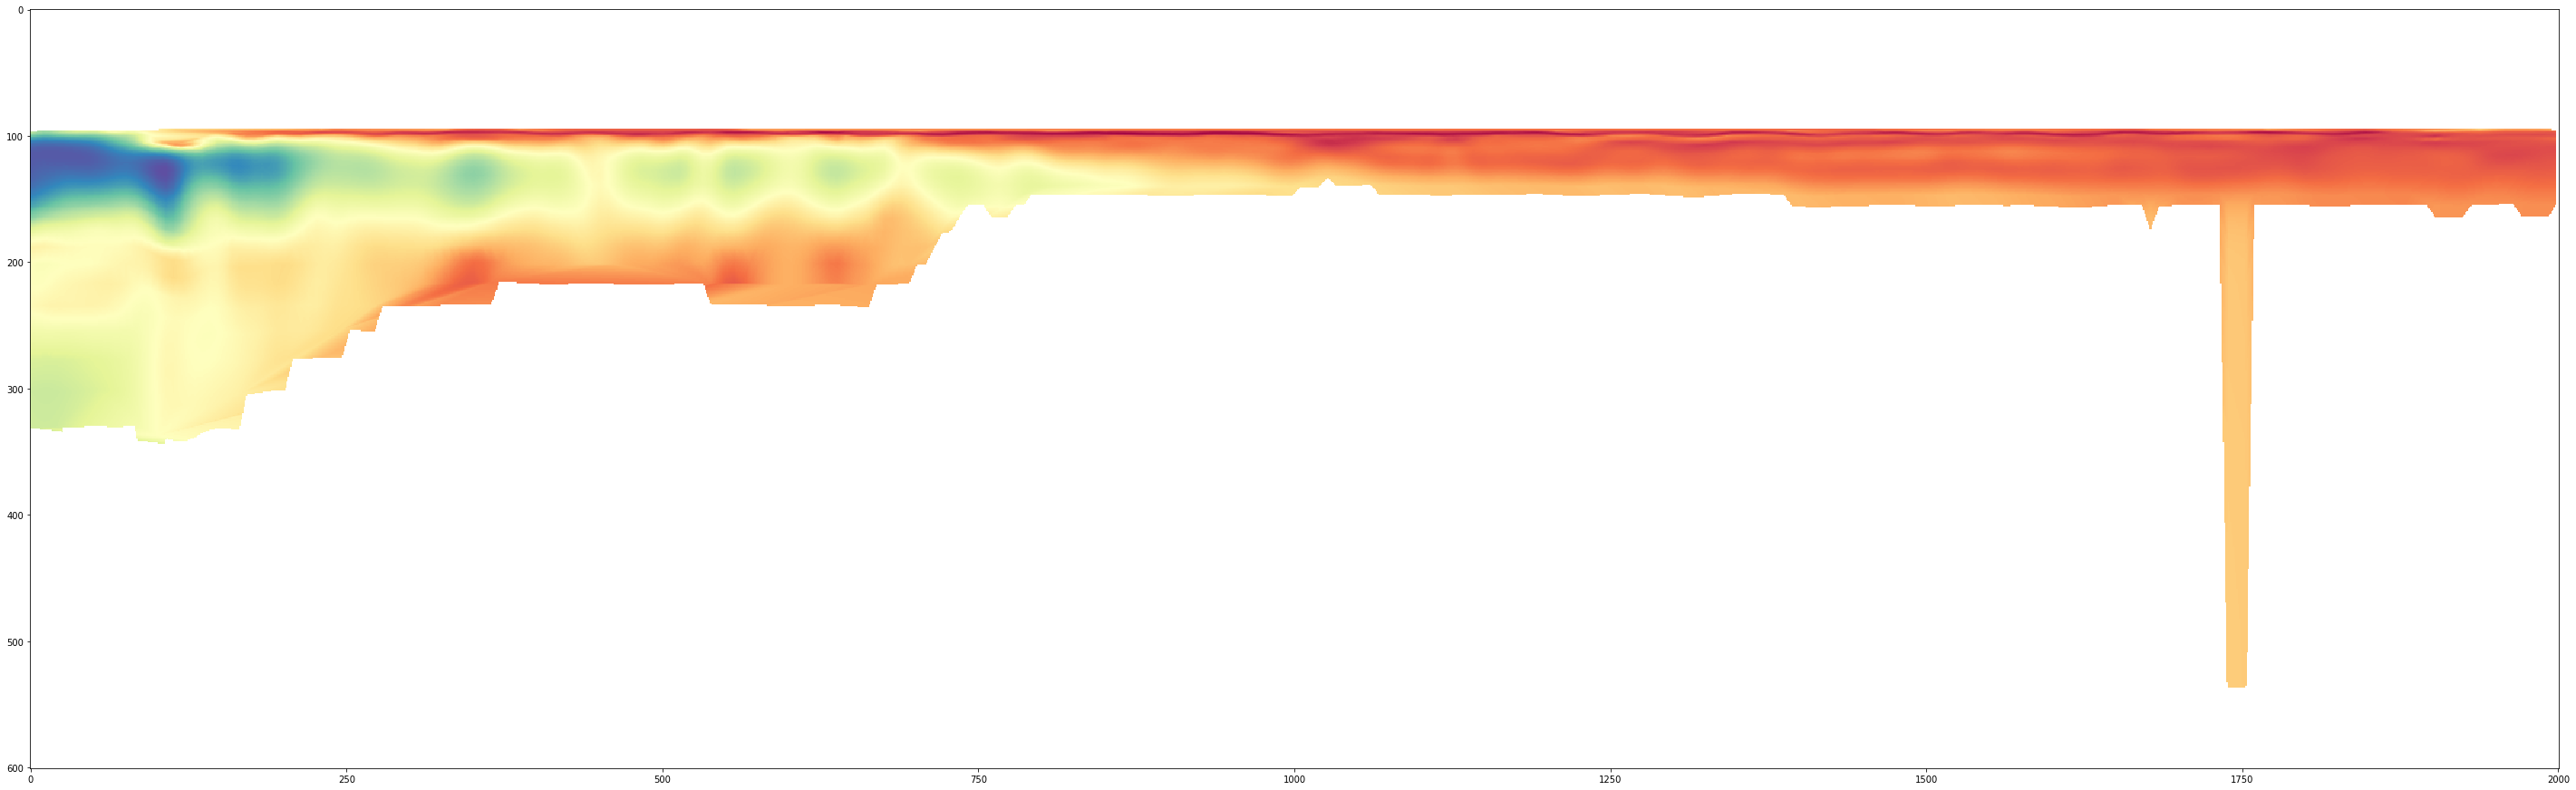

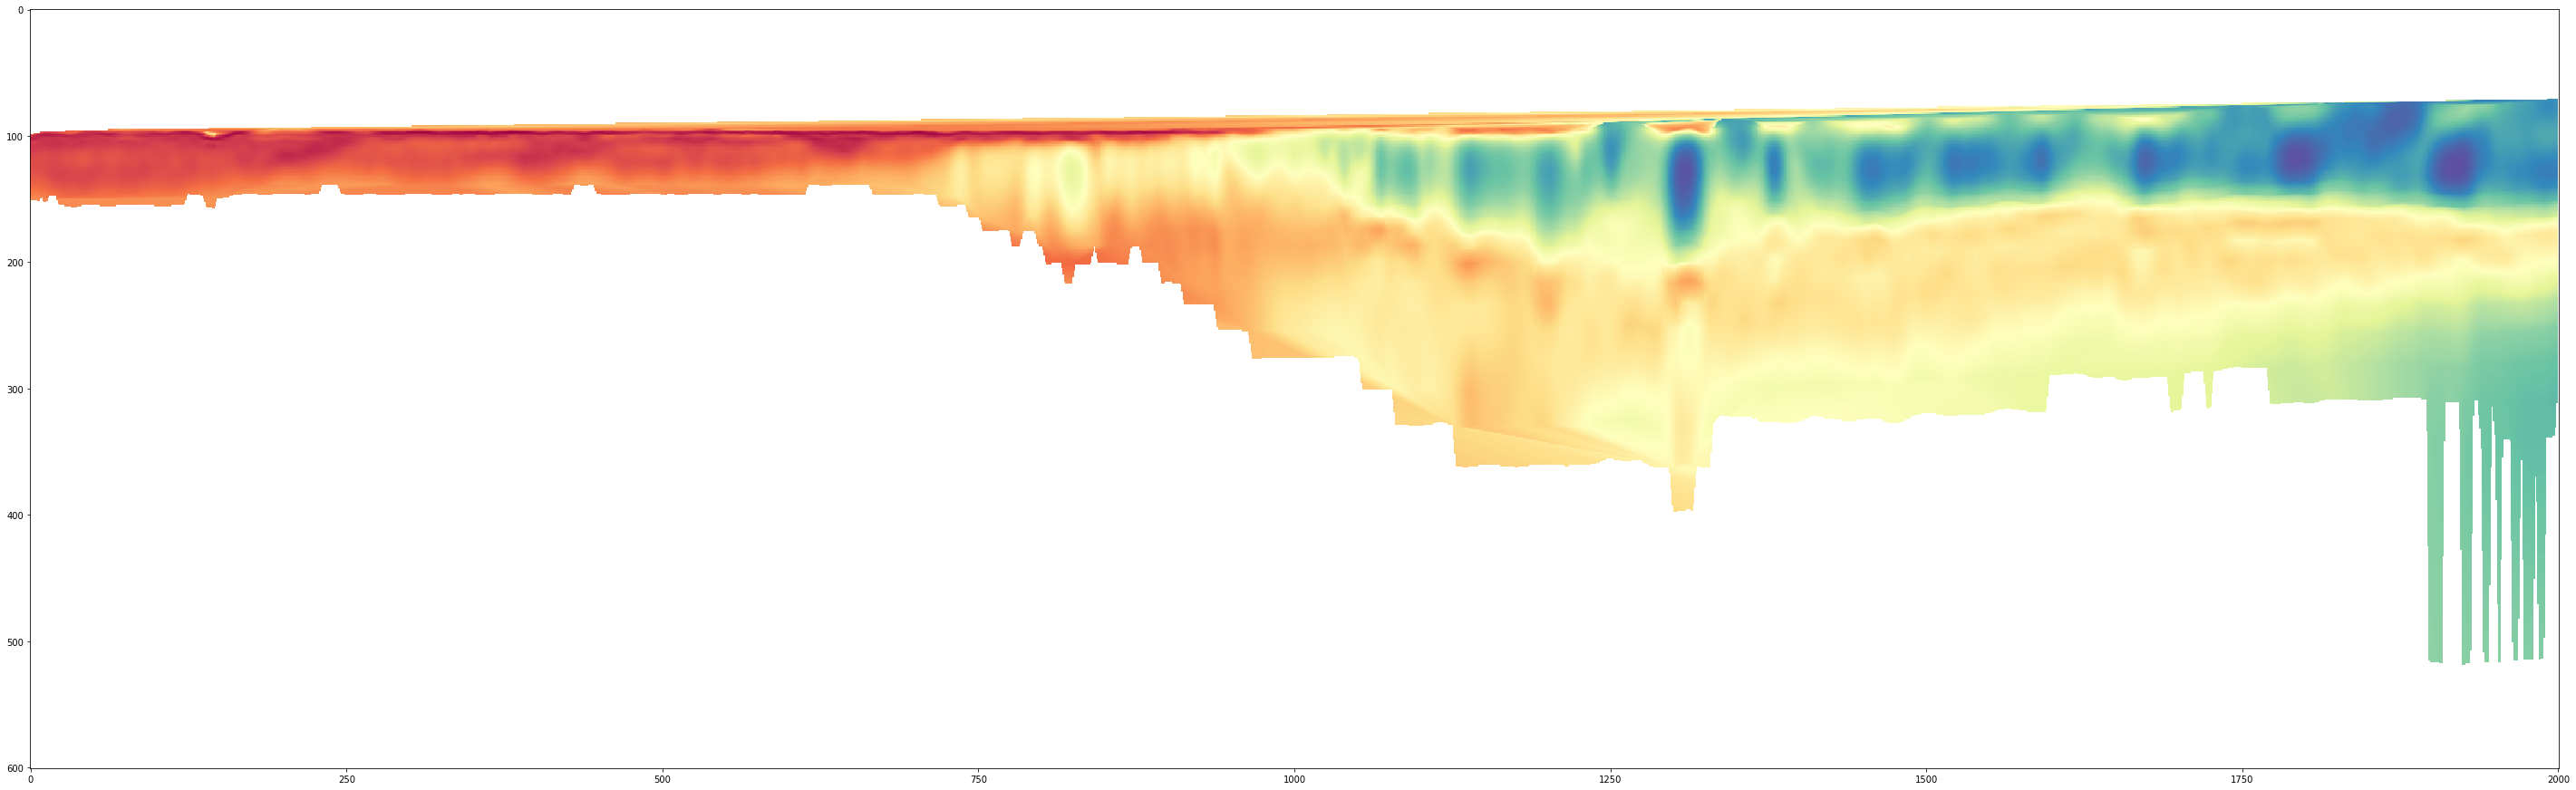

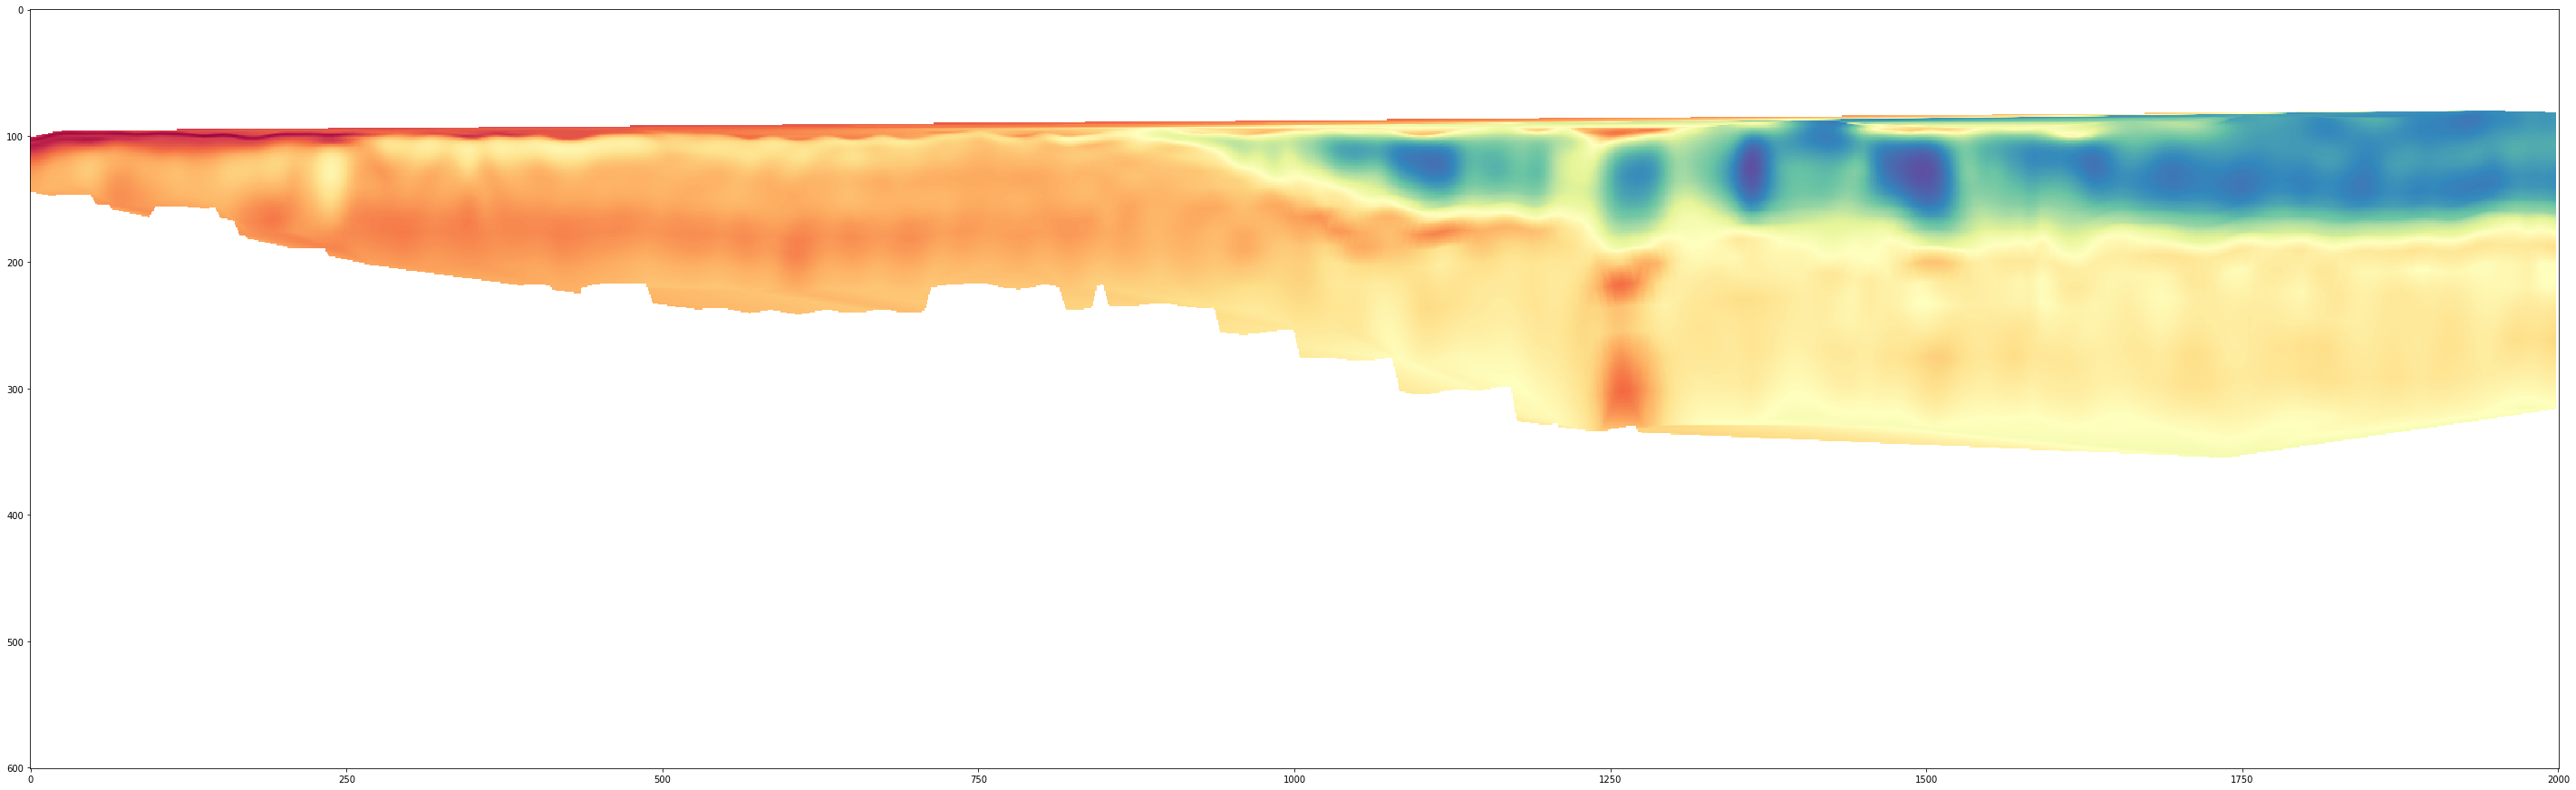

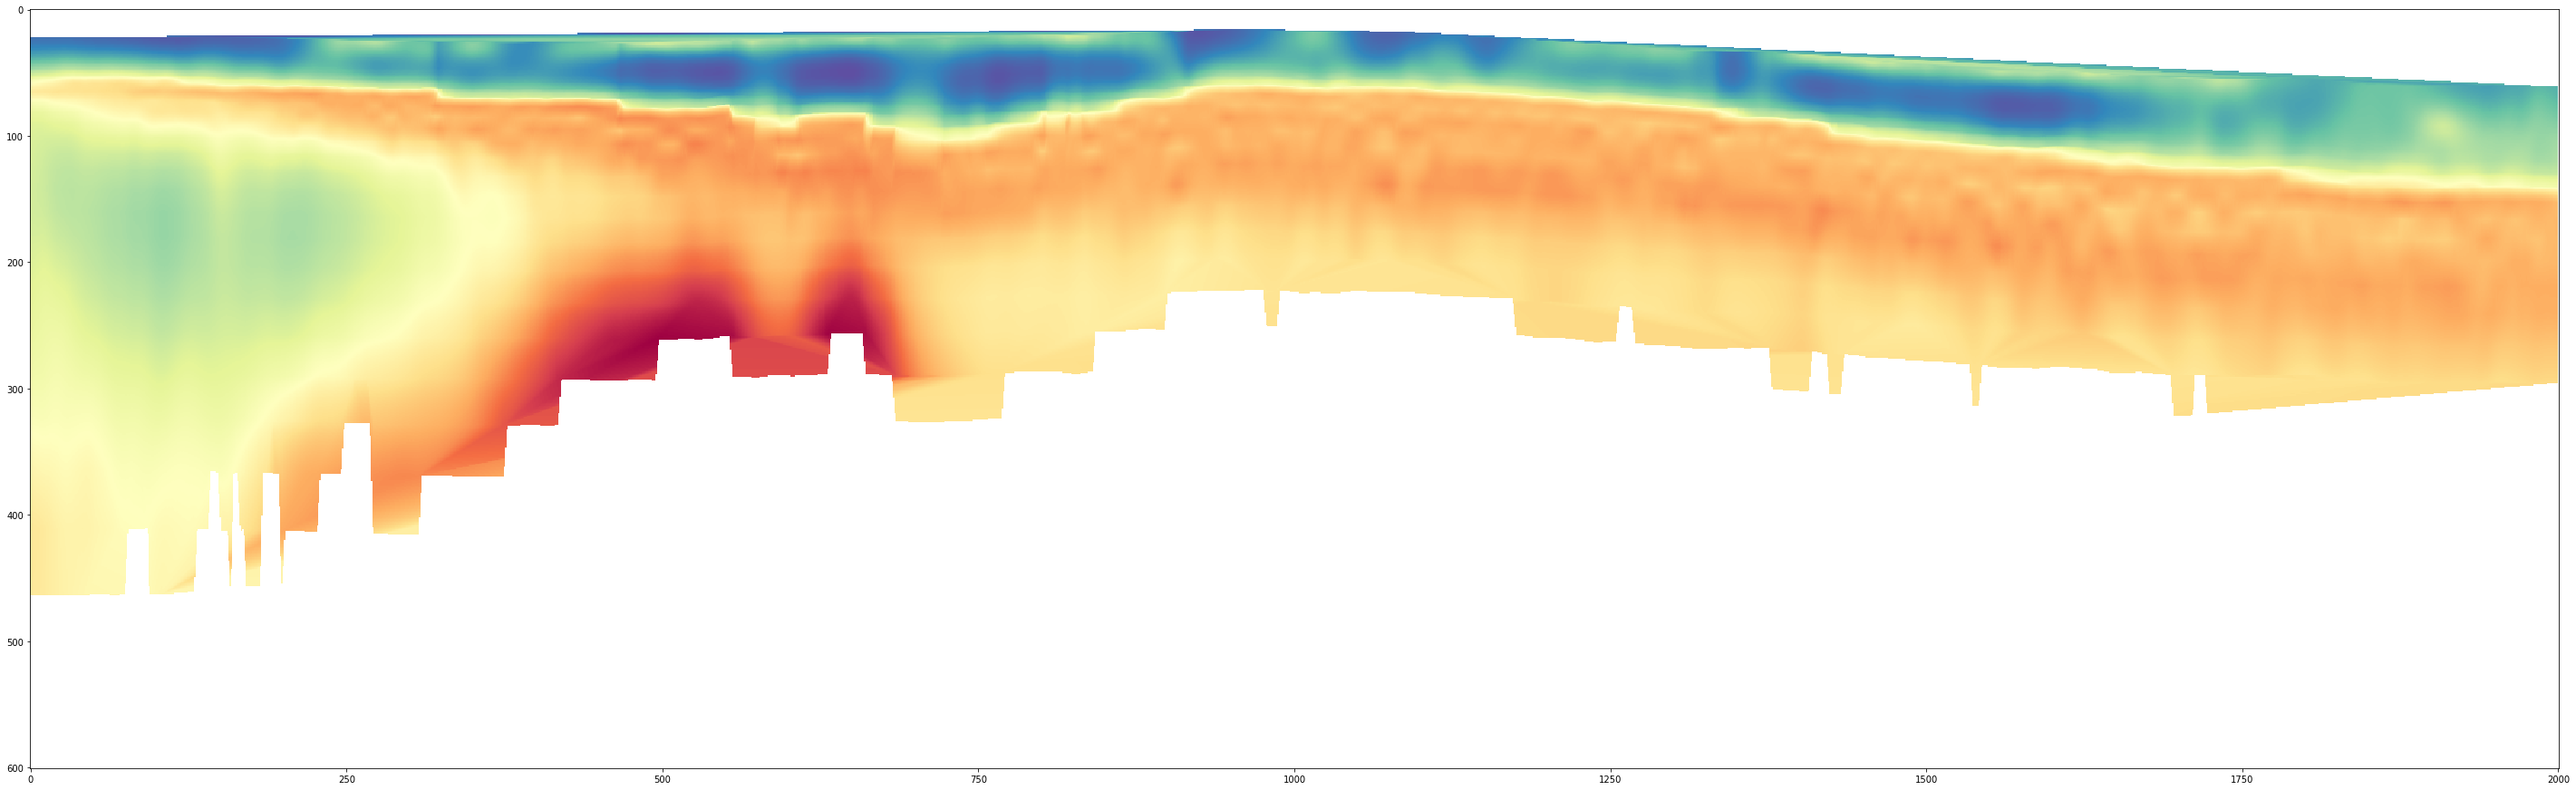

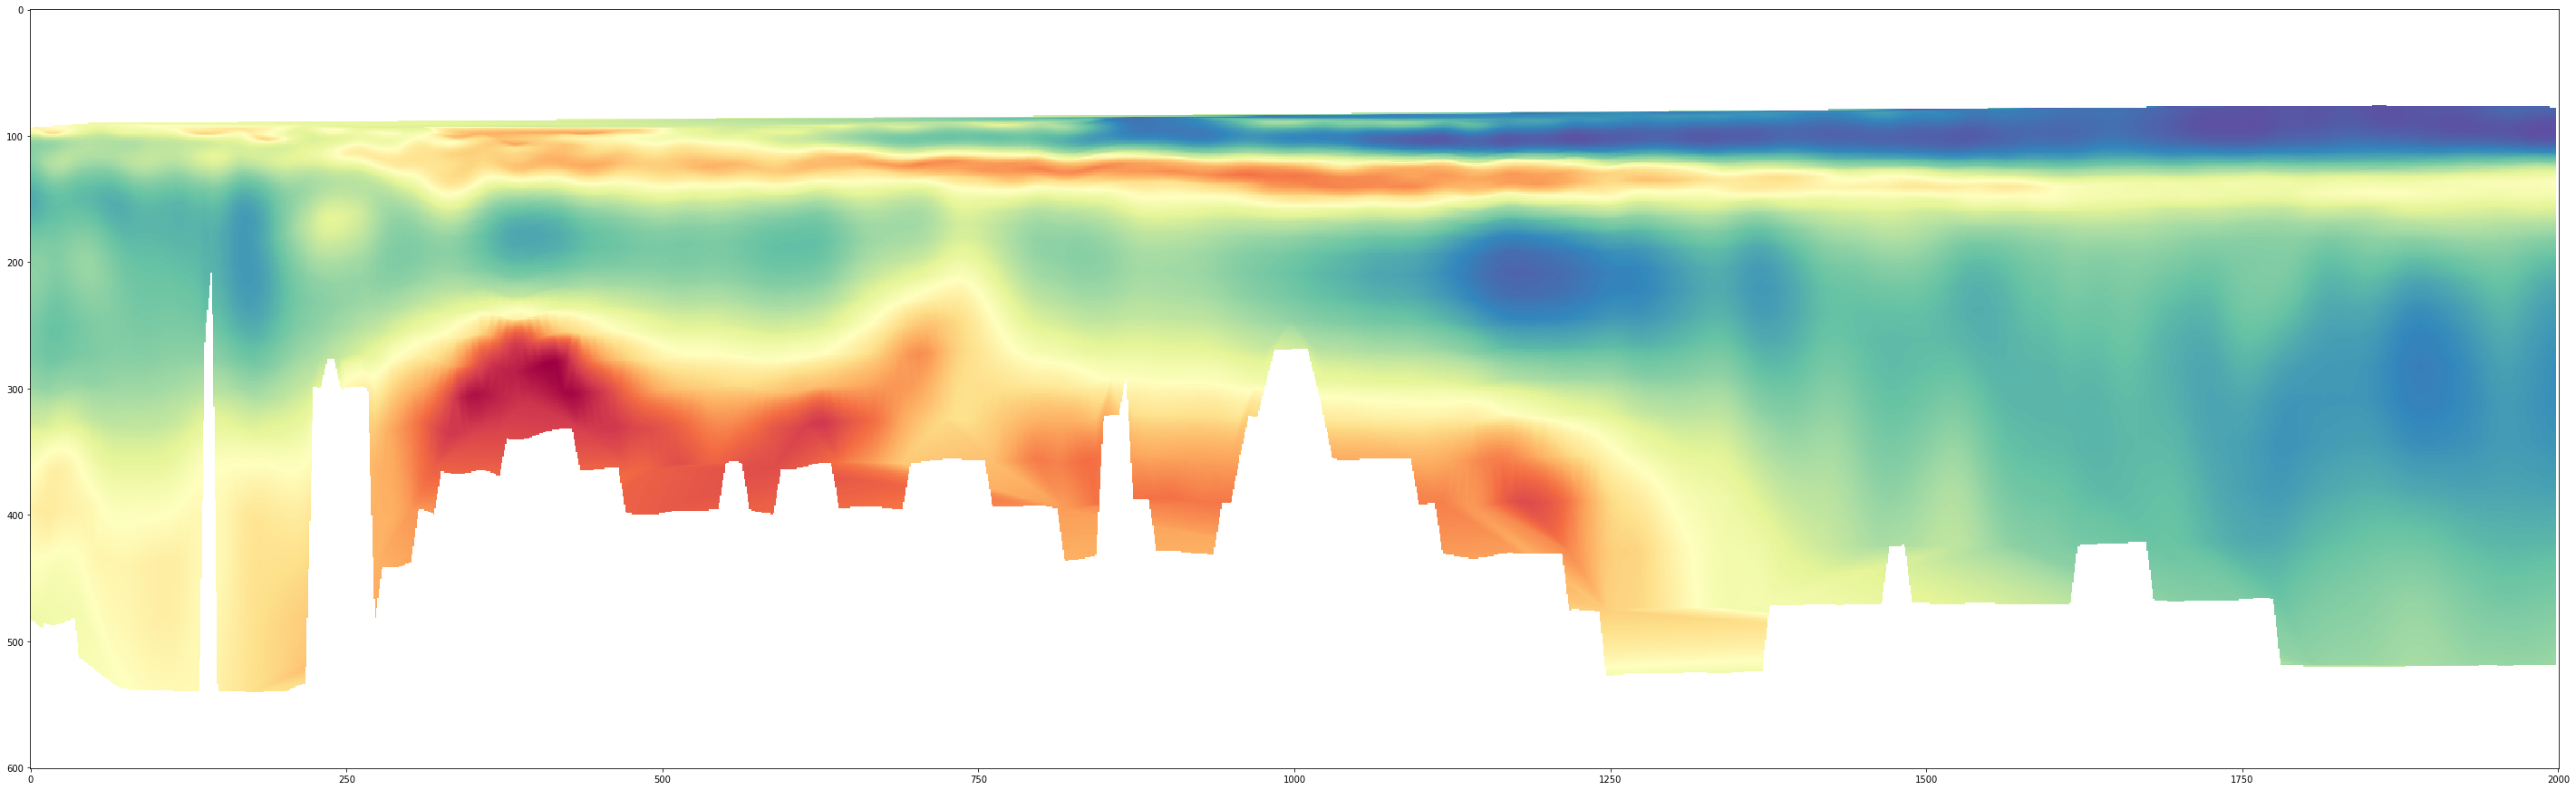

In [10]:
for line_index in range(40,50):
    # Get points in specified line
    line_start = aem_nc_dataset.variables['index_line'][line_index]
    point_count = aem_nc_dataset.variables['index_count'][line_index]
    line_end = line_start + point_count
    line_slice = slice(line_start, line_end)
    
    # Create array of UTM coordinate pairs for all points in selected line
    utm_coordinates = np.zeros(shape=(point_count, 2), dtype=aem_nc_dataset.variables['easting'].dtype)
    utm_coordinates[:,0] = aem_nc_dataset.variables['easting'][line_slice]
    utm_coordinates[:,1] = aem_nc_dataset.variables['northing'][line_slice]
    
    # Compute cumulative distance along line for each point
    distances = coords2distance(utm_coordinates)
    
    # Obtain top elevation for each layer at each point
    layer_top_elevations = aem_nc_dataset.variables['layer_top_elevation'][line_slice]

    # Obtain conductivity for each layer at each point
    layer_conductivities = aem_nc_dataset.variables['layer_conductivity_masked'][line_slice].filled(np.NaN)
    
    # Complete elevation array for layer samples indexed by point and layer
    sublayer_elevations = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                              dtype=layer_top_elevations.dtype) * np.NaN
    
    # Complete conductivity array for layer samples indexed by point and layer
    sublayer_conductivities = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                                      dtype=layer_conductivities.dtype) * np.NaN
    
    # Array of minimum elevations for each point
    min_elevation = np.ones(shape=(layer_top_elevations.shape[0],), 
                            dtype=layer_top_elevations.dtype) * np.NaN
    
    # Sub-sample layers for later interpolation. Remember minimum valid elevation for each point
    for point_index in range(layer_top_elevations.shape[0]):
        for layer_index in range(layer_top_elevations.shape[1]):
            try:
                layer_thickness = layer_top_elevations[point_index, layer_index] - layer_top_elevations[point_index, layer_index + 1]
            except:
                break
                
            if np.isnan(layer_conductivities[point_index, layer_index]):
                break
                
            #print(layer_top_elevations[point_index, layer_index], layer_thickness, layer_conductivities[point_index, layer_index])
            min_elevation[point_index] = layer_top_elevations[point_index, layer_index + 1]
            
            for sublayer_index in range(layer_subdivisions):
                sublayer_elevations[point_index, layer_index*layer_subdivisions+sublayer_index] = layer_top_elevations[point_index, layer_index] - sublayer_index * layer_thickness / layer_subdivisions 
                sublayer_conductivities[point_index, layer_index*layer_subdivisions+sublayer_index] = layer_conductivities[point_index, layer_index]
        
    # Create complete grid of sub-layer point distances for every point/layer - needed for interpolation
    point_distances = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                                      dtype=layer_top_elevations.dtype) * np.NaN
    for depth_index in range(point_distances.shape[1]):
        point_distances[:,depth_index] = distances
    
    # Obtain good data mask to discard invalid layer samples
    good_data_mask = np.logical_and(~np.isnan(sublayer_elevations), ~np.isnan(sublayer_conductivities))
    
    # Discard invalid points and store distance/elevation coordinates in dense array
    point_distance_elevation = np.ones(shape=(np.count_nonzero(good_data_mask), 2), 
                                      dtype=layer_top_elevations.dtype) * np.NaN
    point_distance_elevation[:,0] = point_distances[good_data_mask]
    point_distance_elevation[:,1] = sublayer_elevations[good_data_mask]
    
    # Discard invalid conductivity points
    point_conductivity = sublayer_conductivities[good_data_mask]
    
    # Compute distance range for bitmap
    distance_range = (math.floor(min(point_distance_elevation[:,0]) / 10.0) * 10.0, 
                       math.ceil(max(point_distance_elevation[:,0]) / 10.0) * 10.0)
    
    # Compute elevation range for bitmap
#    elevation_range = (math.floor(min(point_distance_elevation[:,1]) / 10.0) * 10.0, 
#                       math.ceil(max(point_distance_elevation[:,1]) / 10.0) * 10.0)
    
    xres = (distance_range[1] - distance_range[0]) / 2000.0 # Stretch horizontal dynamically
    elevation_range = (-500.0, 100.0) # Fixed elevation range
    
    # Compute regular grid for resampling
    grid_y, grid_x = np.mgrid[elevation_range[1]:elevation_range[0]-yres/2.0:-yres, 
                              distance_range[0]:distance_range[1]+xres/2.0:xres]
    
    # Compute interpolated 1D array of minimum valid elevation values for each X
    min_elevation_grid = griddata(point_distances[:,0],
                                  min_elevation,
                                  grid_x[0], 
                                  method=resampling_method)
    
    # Resample point-wise conductivity into regular grid for bitmap
    conductivity_grid = griddata(point_distance_elevation[:,::-1],
             point_conductivity,
             (grid_y, grid_x), 
             method=resampling_method)
    
    # Purge interpolated values for all elevations < minimum valid elevation
    for x_index in range(conductivity_grid.shape[1]):
        min_elevation_indices = np.where(grid_y[:,x_index] < min_elevation_grid[x_index])[0]
        #print min_elevation_indices
        try:
            conductivity_grid[min_elevation_indices, x_index] = np.NaN
        except:
            pass
    
    #  Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gi
        
    # Plot logarithmic colour stretch (linear stretch on log values)
    print('Line {} is of length {}m'.format(aem_nc_dataset.variables['line'][line_index], max(point_distance_elevation[:,0])))
    plt.figure(figsize=(50,50))    
    plt.imshow(np.log(conductivity_grid), cmap='Spectral_r')
